In [24]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# base_model = ResNet50(weights='imagenet', include_top=False)


In [25]:
model = Sequential([
    
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(256,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(512,activation='relu'),
    # Dense(117,activation='softmax')
    Dense(6,activation='softmax')
])

# Should add metric=[...]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\labledCountries\train'
validation_data_dir = r'..\Data\labledCountries\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [28]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    # shuffle=True
    )

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')


Found 14385 images belonging to 6 classes.
Found 1761 images belonging to 6 classes.


In [29]:
import numpy as np

class_counts = np.bincount(train_generator.classes) ** 0.01

# class_probabilities = class_counts
class_probabilities = class_counts / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)
# class_probabilities[44] = 0
class_probabilities = class_probabilities / np.sum(class_probabilities)
class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


Poland: 0.08976698368275676
Sweden: 0.10378101891361186
Mexico: 0.11185211885193089
Norway: 0.16316399181458985
Finland: 0.18271848835968563
Denmark: 0.3487173983774251


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    # steps_per_epoch=2000,
    validation_data=validation_generator,
    # validation_steps=200,
    batch_size=32,
    epochs=1,
    # class_weight = class_weights,
    # verbose=1
    callbacks=[early_stopping]
)

450/450 [==============================] - 151s 329ms/step - loss: 1.5052 - categorical_accuracy: 0.3942 - val_loss: 1.4053 - val_categorical_accuracy: 0.4605


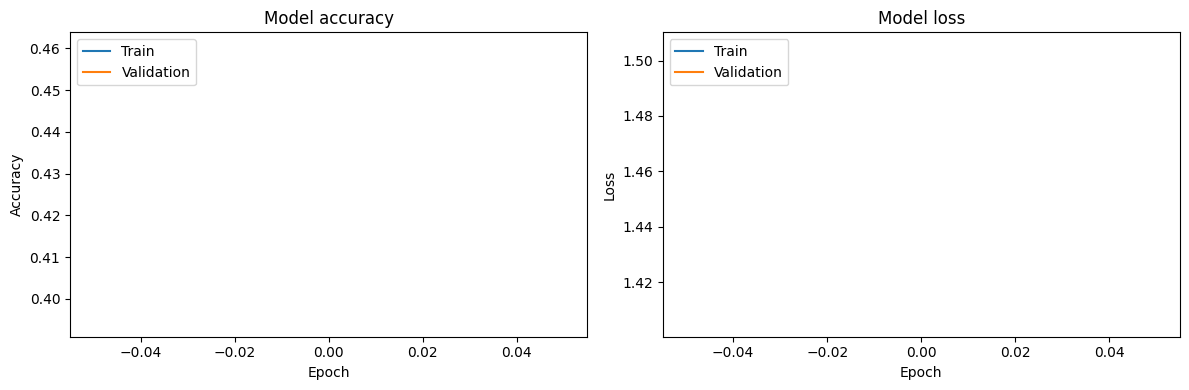

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [32]:
model.save('my_model.h5')


c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\labledCountries\test'
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

class_names = test_generator.class_indices.keys()

Found 1828 images belonging to 6 classes.


58/58 [==============================] - 16s 279ms/step
Classification Report: 
              precision    recall  f1-score   support

     Denmark       0.44      0.27      0.33       127
     Finland       0.49      0.21      0.29       239
      Mexico       0.88      0.30      0.45       366
      Norway       0.47      0.55      0.51       236
      Poland       0.45      0.78      0.57       454
      Sweden       0.43      0.47      0.45       406

    accuracy                           0.48      1828
   macro avg       0.53      0.43      0.43      1828
weighted avg       0.54      0.48      0.46      1828



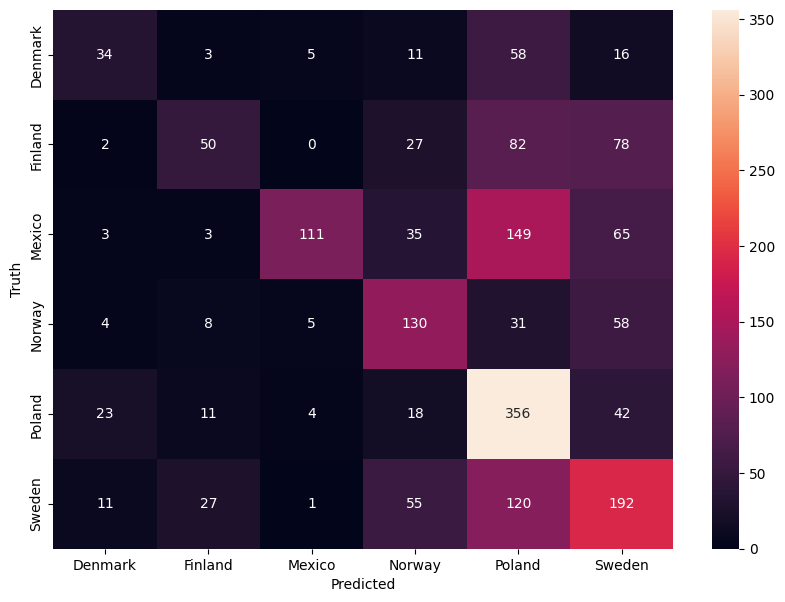

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes

# Predict the values from the validation dataset
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# classification report
print('Classification Report: ')
print(classification_report(y_true, y_pred_classes, target_names=class_names))


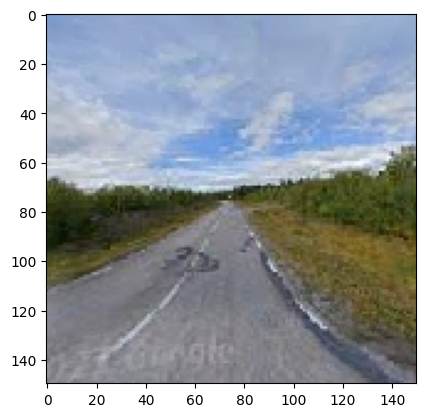

1/1 [==============================] - 0s 204ms/step
Country: ['Norway'], Probability: 0.33070454001426697
Country: ['Sweden'], Probability: 0.24550792574882507
Country: ['Finland'], Probability: 0.1681717038154602
Country: ['Poland'], Probability: 0.13593989610671997
Country: ['Denmark'], Probability: 0.0886223241686821
Country: ['Mexico'], Probability: 0.031053593382239342


In [35]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load image
img_path = r'..\Data\labledCountries\test\Sweden\_W8U2J5WbusQAdaZkqD9Wg.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Make prediction
predictions = model.predict(x)

# Print predictions in sorted order
label_encoder = LabelEncoder()
label_encoder.fit(list(class_names))

for i in np.argsort(predictions[0])[::-1]:
    print(f'Country: {label_encoder.inverse_transform([i])}, Probability: {predictions[0][i]}')


In [36]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
